In [1]:
import os 
import pandas as pd 
import sys 
import re 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path,'..','..'))  # '..','..','..'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from pipeline.plotting.TS_analysis import plot_TS
from pipeline.plotting.plotting_boxplot_metrics import plot_boxplot_on_metric
from experiences.convert_df_to_latex import dataframe_to_latex,parse_index_exp1_2,parse_index_exp4
from experiences.convert_df_to_latex import update_df_metrics,load_csv
from experiences.convert_df_to_latex import tackle_trial_j as tackle_trial_for_distrib
from experiences.common_results import dic_exp_to_names,find_baseline,dic_trials

folder_path = '../../save/K_fold_validation/training_wo_HP_tuning'  # '../../save'


In [2]:
for exp_i,trials in dic_trials.items():
    if exp_i == 'set_experience_HERE' :#'Exp1_subway_in': #'set_experience_HERE': # set_experience_HERE # 'Exp1_subway_in'# 'Exp4_15min' # 'Exp4' # 'Exp3_bike_15min_h4' # 'Exp3' # 'Exp1'
        for trial_j in trials:
            df_j_all = pd.DataFrame()
            for n_bis in range(1,6):
                file_path = f"{folder_path}/{exp_i}/{dic_exp_to_names[exp_i]}/{trial_j}_bis{n_bis}/Losses_{trial_j}_bis{n_bis}.csv"
                df_j = pd.read_csv(file_path,index_col = 0)
                df_j.columns = [f'Train_{n_bis}',f'Valid_{n_bis}']
                df_j_all = pd.concat([df_j_all,df_j],axis=1)
            plot_TS(df_j_all,width=1500,height=400,bool_show=True,title=f"{exp_i}, {trial_j}",x_datetime = False)


In [3]:
import os 
import pandas as pd 
from pipeline.plotting.TS_analysis import plot_TS

def tackle_trial_j(folder_path,dic_exp_to_names,L_metrics,exp_i,trial_j,metrics,plot_losses):
    df_j_all = pd.DataFrame()
    metric_i = []
    for n_bis in range(1,6):
        df_j_all, metric_i = load_csv(folder_path,dic_exp_to_names,exp_i,trial_j,n_bis,df_j_all,metric_i,metrics)

    metric_i = pd.DataFrame(pd.DataFrame(metric_i).agg(['mean','std']).unstack()).T
    metric_i.index = [f"{trial_j}"]
    L_metrics.append(metric_i)
    if plot_losses:
            plot_TS(df_j_all,width=1500,height=400,bool_show=True,title=f"{exp_i}, {trial_j}",x_datetime = False)
    return L_metrics

folder_path = '../../save/K_fold_validation/training_wo_HP_tuning' # ../../
metrics = ['rmse','mae','mase']
plot_losses = False 


for exp_i,trials in dic_trials.items():
    if exp_i == 'Exp2_rainy':
        continue
    print(f"\n------------------ {exp_i} ---")
    L_metrics = []
    if exp_i == 'Exp4_15min_h1':
        exp_i_tmp = 'Exp4_15min'
    else:
        exp_i_tmp = exp_i

    for trial_j in trials:
        L_metrics = tackle_trial_j(folder_path,dic_exp_to_names,L_metrics,exp_i_tmp,trial_j,metrics,plot_losses)

    if exp_i == 'Exp2':
        exp_i_tmp = 'Exp3_bike_15min_h4'
        trial_j = 'STAEformer_bike_out_calendar__e200_h4'
        L_metrics = tackle_trial_j(folder_path,dic_exp_to_names,L_metrics,exp_i_tmp,trial_j,metrics,plot_losses)

    if exp_i == 'Exp3_bike_15min_h4':
        exp_i_tmp = 'Exp4_15min'
        trial_j = 'STAEformer_bike_out_calendar__e80_h4'
        L_metrics = tackle_trial_j(folder_path,dic_exp_to_names,L_metrics,exp_i_tmp,trial_j,metrics,plot_losses)
    df_metrics_all = pd.concat(L_metrics)

    horizons = list(set([c[0].split('_')[-1][1:] for c in df_metrics_all.columns]))
    for horizon in horizons:
        df_horizon = df_metrics_all[[c for c in df_metrics_all.columns if c[0].endswith(f"_h{horizon}")]].dropna()

        globals()[f"df_metrics_{exp_i}_h{horizon}"] = df_horizon.sort_values(by=[(f'rmse_h{horizon}','mean')])

        baseline_index = find_baseline(exp_i,h=horizon)
        for c in globals()[f"df_metrics_{exp_i}_h{horizon}"].columns:
            if 'mean' == c[1]:
                globals()[f"df_metrics_{exp_i}_h{horizon}"][c] = globals()[f"df_metrics_{exp_i}_h{horizon}"][c].apply(lambda x: f"{round(x,2)} ({round(100*(-1+x/globals()[f'df_metrics_{exp_i}_h{horizon}'].loc[baseline_index,c]),2)}\%)")
        
        display(globals()[f"df_metrics_{exp_i}_h{horizon}"])



------------------ Exp1_subway_in ---


FileNotFoundError: [Errno 2] No such file or directory: '../../save/K_fold_validation/training_wo_HP_tuning/Exp1_subway_in/subway_in_STAEformer/STAEformer_subway_in_subway_out_calendar_early_fusion_shared_embedding__e80_h4_bis1/Losses_STAEformer_subway_in_subway_out_calendar_early_fusion_shared_embedding__e80_h4_bis1.csv'

In [4]:
exp_i = 'Exp1_subway_in' # 'Exp1_subway_out' #'Exp1_subway_in' # 'Exp1' #'Exp4_15min', 'Exp4' #'Exp3_bike_15min_h4' #'Exp3' #'Exp1'
metrics = ['rmse','mae','mase']
trials = dic_trials[exp_i]
print(f"\n------------------ {exp_i} ---")

L_metrics = []
for trial_j in trials:
    L_metrics = tackle_trial_for_distrib(folder_path,dic_exp_to_names,L_metrics,exp_i,trial_j,metrics)

if exp_i == 'Exp4':
    exp_i_tmp = 'Exp3'
    trial_j = 'STAEformer_bike_out_calendar__e200_h1'
    L_metrics = tackle_trial_for_distrib(folder_path,dic_exp_to_names,L_metrics,exp_i_tmp,trial_j,metrics)
if exp_i == 'Exp4_15min':
    exp_i_tmp = 'Exp3_bike_15min_h4'
    trial_j = 'STAEformer_bike_out_calendar__e200_h4'
    L_metrics = tackle_trial_for_distrib(folder_path,dic_exp_to_names,L_metrics,exp_i_tmp,trial_j,metrics)
    
df_metrics_all = pd.concat(L_metrics)



def change_legend(row):
    if row.legend_group == 'Other Methods':
        if 'early_fusion' in row.name:
            return 'Early Fusion Other Methods '
        elif 'late_fusion' in row.name:
            return 'Late Fusion Other Methods '
        else:
            return row.legend_group
    else:
        return row.legend_group

def reduce_id(x):
    x = x.replace('late_fusion_','L_')
    x = x.replace('early_fusion_','E_')
    x = x.replace('backbone','BB')
    return x 


configs_to_keep = [
    'Baseline',
    # Model backbone : ---- 
    'late_fusion_traffic_model_backbone_In24_adp16',
    'early_fusion_traffic_model_backbone_In24_adp16',
    # CABB with adpQ = 0 ---
    'early_fusion_CABB_In24_ctxIn8_adp16_adpQ0',
    'late_fusion_CABB_In24_ctxIn8_adp16_adpQ0',
    # CABB with adpQ = 24 ---
    'early_fusion_CABB_In24_ctxIn8_adp16_adpQ24',
    'late_fusion_CABB_In24_ctxIn8_adp16_adpQ24',
    # 'early_fusion_CABB_In24_ctxIn24_adp16_adpQ24',
    # 'late_fusion_CABB_In24_ctxIn24_adp16_adpQ24',
    
    # Others ---
    'late_fusion_simple_embedding',
    'early_fusion_shared_embedding',
    'early_fusion_independant_embedding'   
] 
# configs_to_keep = None 

palette = ['#4e79a7','#f28e2b','#e15759', '#59a14f', '#c7e9c0','#1a4314' ]
legend_groups = ['Baseline','Independant Embedding','Shared Embedding','Early Fusion Other Methods ','Late Fusion Other Methods ']
horizons = list(set([c.split('_')[-1][1:] for c in df_metrics_all.columns]))
for horizon in horizons:
    print('\n----------------')
    print(f"Horizon: {horizon}")
    df_horizon = df_metrics_all[[c for c in df_metrics_all.columns if c.endswith(f"_h{horizon}")]].dropna()

    df_horizon = update_df_metrics(df_horizon,exp_i)
    df_horizon['legend_group'] = df_horizon.apply(change_legend,axis = 1)

    if configs_to_keep is not None: 
        df_horizon = df_horizon[df_horizon['id'].isin(configs_to_keep)]
        df_horizon['id'] = df_horizon['id'].apply(reduce_id)

    plot_boxplot_on_metric(df_horizon, metric_i='mae', xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                save_path=None,palette =palette ,legend_groups =legend_groups )
    plot_boxplot_on_metric(df_horizon, metric_i='rmse', xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                save_path=None,palette =palette ,legend_groups =legend_groups)
    # plot_boxplot_on_metric(df_horizon, metric_i='mase', xaxis_label="Config", legend_group='legend_group', width=1200, height=400, 
    #                             save_path=None)
    


------------------ Exp1_subway_in ---


FileNotFoundError: [Errno 2] No such file or directory: '../../save/K_fold_validation/training_wo_HP_tuning/Exp1_subway_in/subway_in_STAEformer/STAEformer_subway_in_subway_out_calendar_early_fusion_shared_embedding__e80_h4_bis1/Losses_STAEformer_subway_in_subway_out_calendar_early_fusion_shared_embedding__e80_h4_bis1.csv'

In [8]:
# --- Captions Dictionary ---
captions = {
    "Exp1": r"Prediction of Subway-Out with STAEformer using contextual data 'Subway-In' according to different Integration Strategies. Metrics are averaged over 5 runs.",
    "Exp1_subway_in": r"Prediction of Subway-In with STAEformer using contextual data 'Subway-Out' according to different Integration Strategies. Metrics are averaged over 5 runs.",
    "Exp1_subway_out": r"Prediction of Subway-Out with STAEformer using contextual data 'Subway-In' according to different Integration Strategies. Metrics are averaged over 5 runs.",
    "Exp2": r"Prediction of Bike-Out (15min aggregation) at a 60-minute horizon with STAEformer, using weather forecasts as contextual data. Metrics are averaged over 5 runs.",
    "Exp4": r"Prediction of Bike-Out with STAEformer using heterogenous contextual data 'subway-in-subway-out' (1h aggregation) at horizon +60min. The table compares the baseline with different configurations of the CrossAttnBackBone model. Metrics are averaged over 5 runs.",
    "Exp4_15min": r"Prediction of Bike-Out with STAEformer using heterogenous contextual data 'subway-in-subway-out' (15min aggregation) at horizon +60min. This table compares various CrossAttnBackBone model configurations. Metrics are averaged over 5 runs.",
     "Exp4_15min_h1": r"Prediction of Bike-Out with STAEformer using heterogenous contextual data 'subway-in-subway-out' (15min aggregation) at horizon +15min. This table compares various CrossAttnBackBone model configurations. Metrics are averaged over 5 runs.",
}

# --- Generate and Print LaTeX Tables ---
print("%%% LaTeX code for Experiment 1 Table %%%\n")
latex_table_1 = dataframe_to_latex(df_metrics_Exp1_h4, captions["Exp1"], "exp1_subway_context", parse_index_exp1_2)
print(latex_table_1)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 1 Horizon +60min Table %%%\n")
latex_table_1 = dataframe_to_latex(df_metrics_Exp1_subway_in_h1, captions["Exp1_subway_in"], "exp1_subway_context", lambda x: parse_index_exp1_2(x, contextual='subway_out'))
print(latex_table_1)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 1 Horizon +60min Table %%%\n")
latex_table_1 = dataframe_to_latex(df_metrics_Exp1_subway_in_h4, captions["Exp1_subway_in"], "exp1_subway_context", lambda x: parse_index_exp1_2(x, contextual='subway_out'))
print(latex_table_1)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 1 Horizon +15min Table %%%\n")
latex_table_1 = dataframe_to_latex(df_metrics_Exp1_subway_out_h1, captions["Exp1_subway_out"], "exp1_subway_context", lambda x: parse_index_exp1_2(x, contextual='subway_in'))
print(latex_table_1)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 1 Horizon +15min Table %%%\n")
latex_table_1 = dataframe_to_latex(df_metrics_Exp1_subway_out_h4, captions["Exp1_subway_out"], "exp1_subway_context", lambda x: parse_index_exp1_2(x, contextual='subway_in'))
print(latex_table_1)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 2 Table %%%\n")
# Note: parse_index_exp1_2 is reused as it correctly handles the index format for Exp2
latex_table_2 = dataframe_to_latex(df_metrics_Exp2_h4, captions["Exp2"], "exp2_bike_weather", parse_index_exp1_2)
print(latex_table_2)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 4 Table %%%\n")
latex_table_4 = dataframe_to_latex(df_metrics_Exp4_h1, captions["Exp4"], "exp4_bike_hetero", parse_index_exp4)
print(latex_table_4)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 4 (15min) at horizon +60min Table %%%\n")
# Note: parse_index_exp4 is reused as it correctly handles the index format for Exp4_15min
latex_table_4_15min = dataframe_to_latex(df_metrics_Exp4_15min_h4, captions["Exp4_15min"], "exp4_bike_hetero_15min", parse_index_exp4)
print(latex_table_4_15min)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 4 (agg 15min) at horizon + 15min Table %%%\n")
latex_table_4_15min_h1 = dataframe_to_latex(df_metrics_Exp4_15min_h4, captions["Exp4_15min_h1"], "exp4_bike_hetero_15min", parse_index_exp4)
print(latex_table_4_15min_h1)

print("\n" + "="*80 + "\n")


%%% LaTeX code for Experiment 1 Table %%%

\begin{table}[!htb]
    \centering
    \caption{Prediction of Subway-Out with STAEformer using contextual data 'Subway-In' according to different Integration Strategies. Metrics are averaged over 5 runs.}
    \label{tab:exp1_subway_context}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{llcccccc}}
        \toprule
        Contextual Data & Integration Strategy & \multicolumn{2}{c}{ RMSE (h4) } & \multicolumn{2}{c}{ MAE (h4) } & \multicolumn{2}{c}{ MASE (h4) } \\
        \cmidrule(lr){1-2} \cmidrule(lr){3-4} \cmidrule(lr){5-6} \cmidrule(lr){7-8}
         &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        Yes & Early Fusion Feature Extractor & 40.46 (-5.3\%) & 0.1824 & 22.27 (-4.02\%) & 0.0953 & 0.69 (-3.53\%) & 0.0030 \\
        Yes & Early Fusion Shared Embedding & 40.76 (-4.61\%) & 0.4171 & 22.3 (-3.88\%) & 0.2049 & 0.69 (-3.38\%) & 0.0064 \\
        Yes & Late Fusion Traffic Model Backbone & 40.8 (-4.52\%) & 0.2193 & 


    Experiment: Exp1

    Experiment: Exp1_subway_in

    Experiment: Exp1_subway_out

    Experiment: Exp2
Exp2
    Horizon h=4
STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_bis
STAEformer_bike_out_weather_calendar_late_fusion_s_proj_t_proj__e200_h4_bis
STAEformer_bike_out_weather_calendar_late_fusion_repeat_t_proj__e200_h4_bis
STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_bis
STAEformer_bike_out_weather_calendar_early_fusion_s_proj_t_proj__e200_h4_bis
STAEformer_bike_out_weather_calendar_early_fusion_feature_extractor__e200_h4_bis
    trial_id1 STAEformer_bike_out_calendar__e200_h4_bis
    trial_id2 STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_bis
Trial ID 1:  _STAEformer_bike_out_calendar__e200_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/trai

/home/rrochas/prediction-validation/pipeline/clustering/clustering.py:322: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(self.dist_matrix.values, method=self.model.linkage)


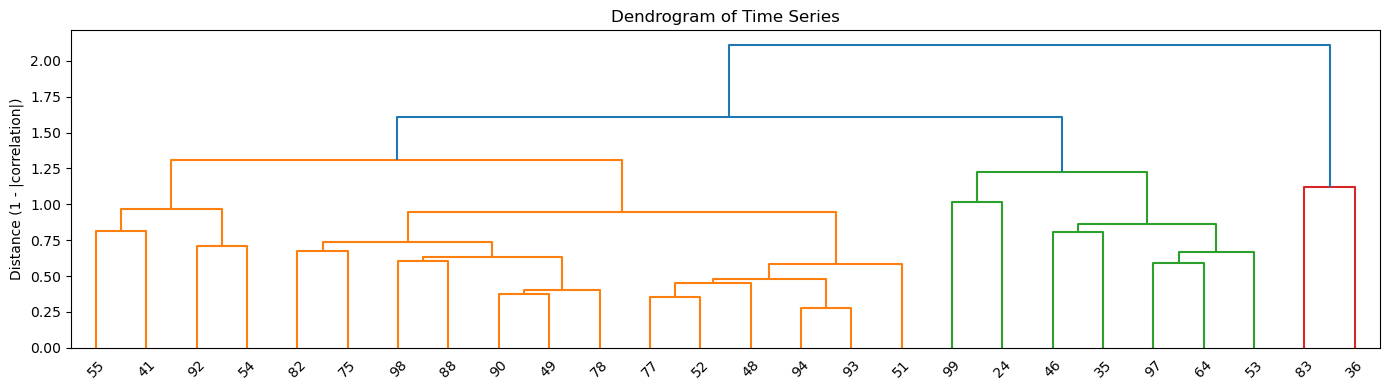

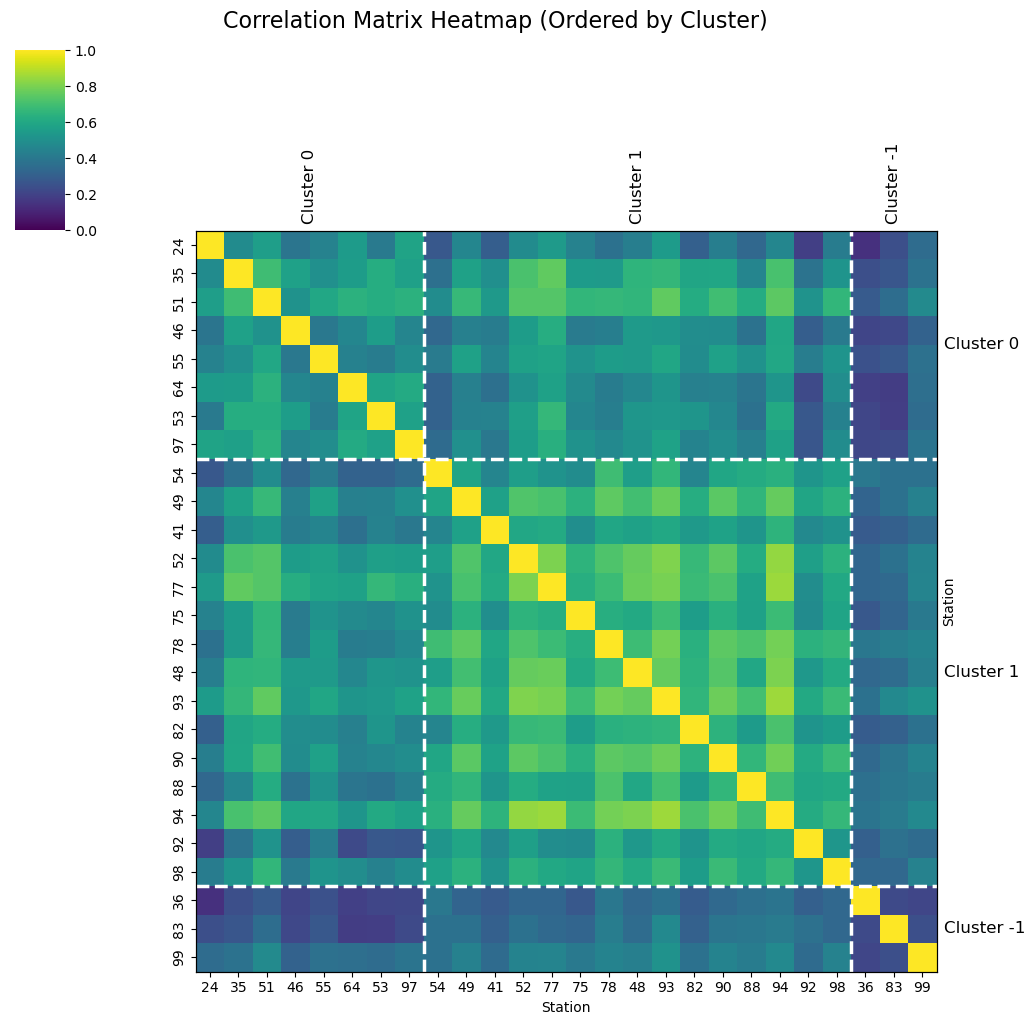

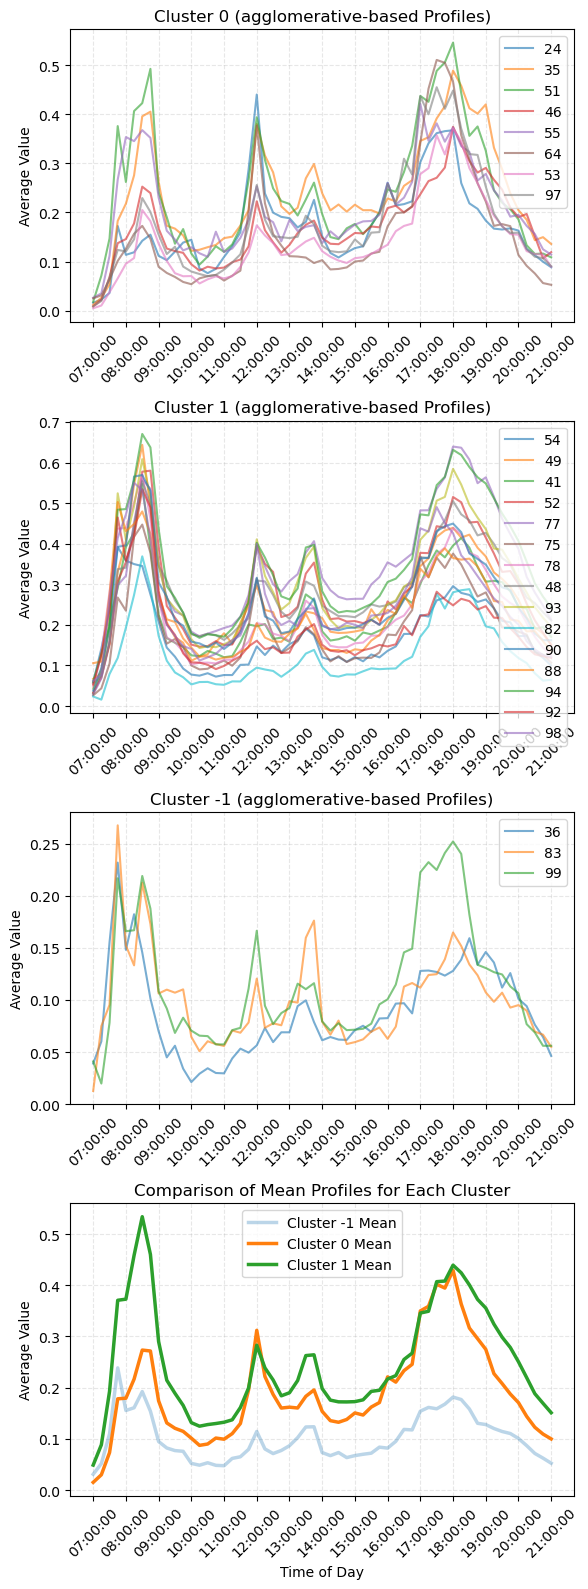

Model1 correspond to :  STAEformer_bike_out_calendar__e200_h4_bis
Model2 correspond to :  STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_bis


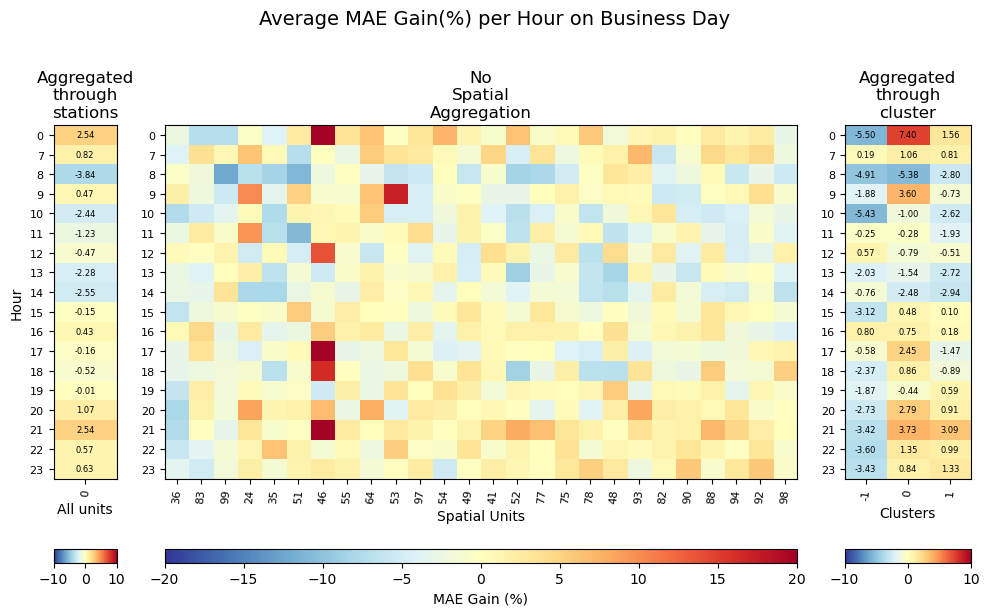


Comparison on between models across all time-slots followed by comparison on Rainy Events Only
Number of rainy time-slots in the train set:
 Between 0 and 0.05 mm: 744, i.e 4.73 % of the train set and 32.99 % of the rainy time-slots
 Between 0.05 and 0.5 mm: 919, i.e 5.84 % of the train set and 40.75 % of the rainy time-slots
 Between 0.5 and 1 mm: 289, i.e 1.84 % of the train set and 12.82 % of the rainy time-slots
 Between 1 and inf mm: 303, i.e 1.93 % of the train set and 13.44 % of the rainy time-slots
Number of rainy time-slots in the train set: 2255, i.e 14.34 % of the train set
Number of rainy time-slots in the test set: 1228, i.e 23.43 % of the test set

Model1 correspond to :  STAEformer_bike_out_calendar__e200_h4_bis
Model2 correspond to :  STAEformer_bike_out_weather_calendar_late_fusion_feature_extractor__e200_h4_bis


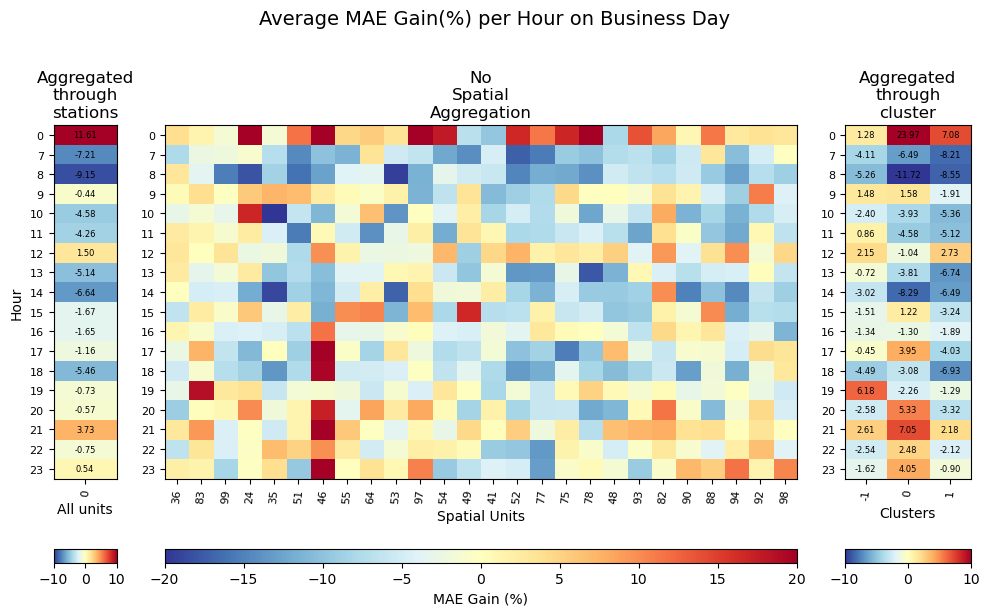



    Experiment: Exp2_rainy

    Experiment: Exp3

    Experiment: Exp3_bike_15min_h4

    Experiment: Exp4

    Experiment: Exp4_15min

    Experiment: Exp4_15min_h1

    Experiment: Exp6_subway_netmob

    Experiment: Exp6_bike_netmob


In [2]:
import os 
import sys

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path,'..','..'))  # '..','..','..'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.accuracy_comparison import get_model_args,get_desagregated_comparison_plot
from experiences.common_results import dic_exp_to_names,dic_trials,find_baseline


issue_while_loading_saved_weights = ''

trial_id1_in_bis = False
trial_id2_in_bis = False
range_k = range(1,6) # range(1,6)
comparison_on_rainy_events = True 
station_clustering = True 

init_folder_path = f"/home/rrochas/prediction-validation/save/plot"

# ---- If folder does not exist in save:
for exp_i in dic_exp_to_names.keys():
    folder_path = f"{init_folder_path}/{exp_i}"
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)


for exp_i,target_model_name in dic_exp_to_names.items():
    print('\n=========================')
    print(f"    Experiment: {exp_i}")
    target_data = '_'.join(target_model_name.split('_')[:-1])
    model_name = target_model_name.split('_')[-1]
    if not (exp_i == 'Exp2'):
        continue

    print(exp_i)
    configs = dic_trials[exp_i]
    for h in [1,4]:
        baseline = find_baseline(exp_i,h=h)
        if (baseline in configs) and baseline.endswith(f"_h{h}"):
            print(f"    Horizon h={h}")
            trial_ids2 = [f"{config}_bis" for config in configs if (config.endswith(f"_h{h}")) and not(baseline == config)]
            trial_ids1 = [f"{baseline}_bis"]*len(trial_ids2)

            if exp_i == 'Exp4_15min_h1':
                exp_i = 'Exp4_15min'
            save_folder_name = f'{exp_i}/{target_data}_{model_name}'
            save_folder_name_bis = None

            model_args,model_args_bis,path_model_args,path_model_args_bis = get_model_args(save_folder_name,save_folder_name_bis)

            for trial_id in trial_ids2:
                print(trial_id)

            for trial_id1,trial_id2 in zip(trial_ids1,trial_ids2):
                print('    trial_id1',trial_id1)
                print('    trial_id2',trial_id2)
                if comparison_on_rainy_events:
                    folder_path = f"{init_folder_path}/{exp_i}_rainy"
                else:
                    folder_path = f"{init_folder_path}/{exp_i}"
                save_name = f"desag_{trial_id2}"
                                   
                outputs = get_desagregated_comparison_plot(trial_id1,trial_id2,
                                                            model_args = model_args,
                                                            model_args_bis = model_args_bis,
                                                            path_model_args = path_model_args,
                                                            path_model_args_bis = path_model_args_bis,
                                                            range_k = range_k,
                                                            trial_id1_in_bis=False,
                                                            trial_id2_in_bis=False,
                                                            comparison_on_rainy_events = comparison_on_rainy_events ,
                                                            station_clustering = station_clustering,
                                                            folder_path = None,
                                                            save_name = save_name,
                                                            heatmap = True,
                                                            daily_profile = True,
                                                            dendrogram = True
                                                            )
                clusterer,full_predict1,full_predict2,train_input,Y_true,L_trainers_1,L_trainers_2,ds1,ds2,args_init1,args_init2 = outputs

                if full_predict1 is None:
                    issue_while_loading_saved_weights +=  f"\nProblem for {trial_id1} vs {trial_id2} in {exp_i}"
                print(issue_while_loading_saved_weights)